# Analytical determination of $\sigma_0$

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.special import gamma
from decimal import Decimal
import pandas as pd

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size']=13
plt.rcParams['font.family']='stix'
plt.rcParams['text.usetex']=True
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150

## Various constants

http://pdg.lbl.gov/2014/reviews/rpp2014-rev-astrophysical-constants.pdf

https://arxiv.org/pdf/1904.10000

https://arxiv.org/pdf/1502.01589.pdf

In [17]:
# Constants
h = 0.6727
H0=67.27
Omega_m = (0.1199)/(h**2)
Omega_b = 0.05
Omega_rad=10e-5
p_crit=4.755e-6
rho_crit = 1.256*10**11*Omega_m
p_b = Omega_b*p_crit
T0 = 2.7255
kb = 8.617333262145e-5
T_0 = kb*T0*1e-9
m_p=0.93827231
Y_p=0.75

# Factors to satisfy units
k_crit_conversionFactor=3.33333333e-6
R_x_conversionFactor=9.258e29

# Mass/sigma arrays
masses = np.array([1e-4,1e-3,1e-2,1e-1,1.,10.])
sigma = np.zeros(len(masses))
sigma_array = np.logspace(-10,-30,200)

---

---

## Relevant functions

$\underline{\text{Equation} \:19:}\:$ https://arxiv.org/pdf/1801.08609.pdf

$ N_0 =  2^{(5+n)/2}\Gamma(3+n/2)/(3\sqrt{\pi})$

In [18]:
def N_0(n):
    return pow(2,(5.+n)/2.)*gamma(3.+n/2.)/(3.*np.sqrt(np.pi))

---

$\underline{\text{Equation} \:9:}\:$ http://sro.sussex.ac.uk/id/eprint/46339/1/MNRAS-2012-Schneider-684-98.pdf

$M_{hm} = \frac{4\pi\bar{\rho}}{3}\big(\frac{\lambda_{hm}}{2}\big)^3$

$\qquad = \frac{4\pi\bar{\rho}}{3}\big(\frac{\pi}{hk_{hm}}\big)^3$

$\therefore k_{hm} = \frac{\pi}{h}\big(\frac{4\pi\bar{\rho}}{3M_{hm}}\big)^{1/3}$

In [30]:
def mhm2khm(Mhm):
    return np.pi/h*(((4.*np.pi*rho_crit)/(3*Mhm))**(1./3.))

---

$\underline{\text{Equation} \:3:}\:$ https://arxiv.org/pdf/1808.00001.pdf

$R_x = \frac{N_0a\rho_bY_p\sigma_0}{m_{\chi}+m_p}\Big(\frac{T_b}{m_p}+\frac{T_{\chi}}{m_{\chi}}\Big)^{\frac{1+n}{2}}$


In [21]:
def R_x(sigma_0, m_x, n):
    return N_0(n)*Y_p*p_b*R_x_conversionFactor*(sigma_0/(m_x+m_p))*(pow((T_0/m_x)+(T_0/m_p),((1.+n)/2.)))

---

$\underline{\text{Equation} \:3:}\:$ https://arxiv.org/pdf/1904.10000

$aH = R_{\chi}(m_{\chi}/(m_{\chi}+m_p))$

Note that $aH \sim z$ and $R_{\chi} \sim z^{n+5/2}$ such that

$zH_0\sqrt{\Omega_{rad}} = R_{\chi}(m_{\chi}/(m_{\chi}+m_p))z^{n+5/2}$

$\therefore z = ((m_{\chi}+m_p)H_0\sqrt{\Omega_{rad}}/R_{\chi}m_{\chi})^{2/n+3}$

In [43]:
def z_th(sigma_0,m_x,n):
    return ((H0*np.sqrt(Omega_rad)*(m_x+m_p))/(R_x(sigma_0,m_x,n)*m_x))**(2./(n+3.))

---

$\underline{\text{Equation} \:1:}\:$ https://arxiv.org/pdf/1904.10000

$aH = R_{\chi} = \frac{N_0a\rho_bY_p\sigma_0}{m_{\chi}+m_p}\Big(\frac{T_b}{m_p}+\frac{T_{\chi}}{m_{\chi}}\Big)^{\frac{1+n}{2}}$

Note that $aH \sim z$, $a\bar{\rho} \sim z^2$, $T_b \sim z$ and $T_{\chi} \sim z^2/z_{th}$, such that

$\frac{H_0\sqrt{\Omega_{rad}}(m_{\chi}+m_p)}{N_0Y_p\rho_b\sigma_0} = z^2/z \big(\frac{T_0z}{m_p}+\frac{T_0z^2}{z_{th}m_{\chi}}\big)^{n+1/2}$

$0 = z \big(\frac{T_0z}{m_p}+\frac{T_0z^2}{z_{th}m_{\chi}}\big)^{n+1/2} - \frac{H_0\sqrt{\Omega_{rad}}(m_{\chi}+m_p)}{N_0Y_p\rho_b\sigma_0}$

Solving the above for $z$ yields $z_{kin}$

In [38]:
def z_kin(sigma_0,m_x,n):
    return fsolve(lambda z: z * ((T_0*z**2)/(z_th(sigma_0,m_x,n)*m_x) + (T_0*z)/m_p)**((n+1.)/2.) - (H0*np.sqrt(Omega_rad)/(N_0(n)*Y_p*p_b*R_x_conversionFactor))*(m_x+m_p)/sigma_0,z_th(sigma_0,m_x,n)/2.)    

---

$\underline{\text{Equation} \:4:}\:$ https://arxiv.org/pdf/1904.10000

$k_{crit} = 2aH = 2H_0\sqrt{\Omega_{rad}}z_{kin}^2/z_{kin} = 2H_0\sqrt{\Omega_{rad}}z_{kin}$

In [44]:
# Equation 4
def sigma2k(sigma_0,m_x,n):
    return 2.*(H0*np.sqrt(Omega_rad)*z_kin(sigma_0,m_x,n))*3.33e-6

---

---

## Plotting of cross section vs dark matter mass

In [40]:
def sig(klimit,n):
    sigma = []
    for i in range(len(masses)):
        sigma.append(sigma_array[np.argmin(np.abs(sigma2k(sigma_array,masses[i],n)-h*klimit))])
    return np.array(sigma)

def sigma_vs_mx(klimit):
    return hv.Curve((masses, sig(klimit)))

In [41]:
sigma2k(np.array([7.924828983539186e-21]),0.0001,6)

array([2.20448122])

/home/maamari/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


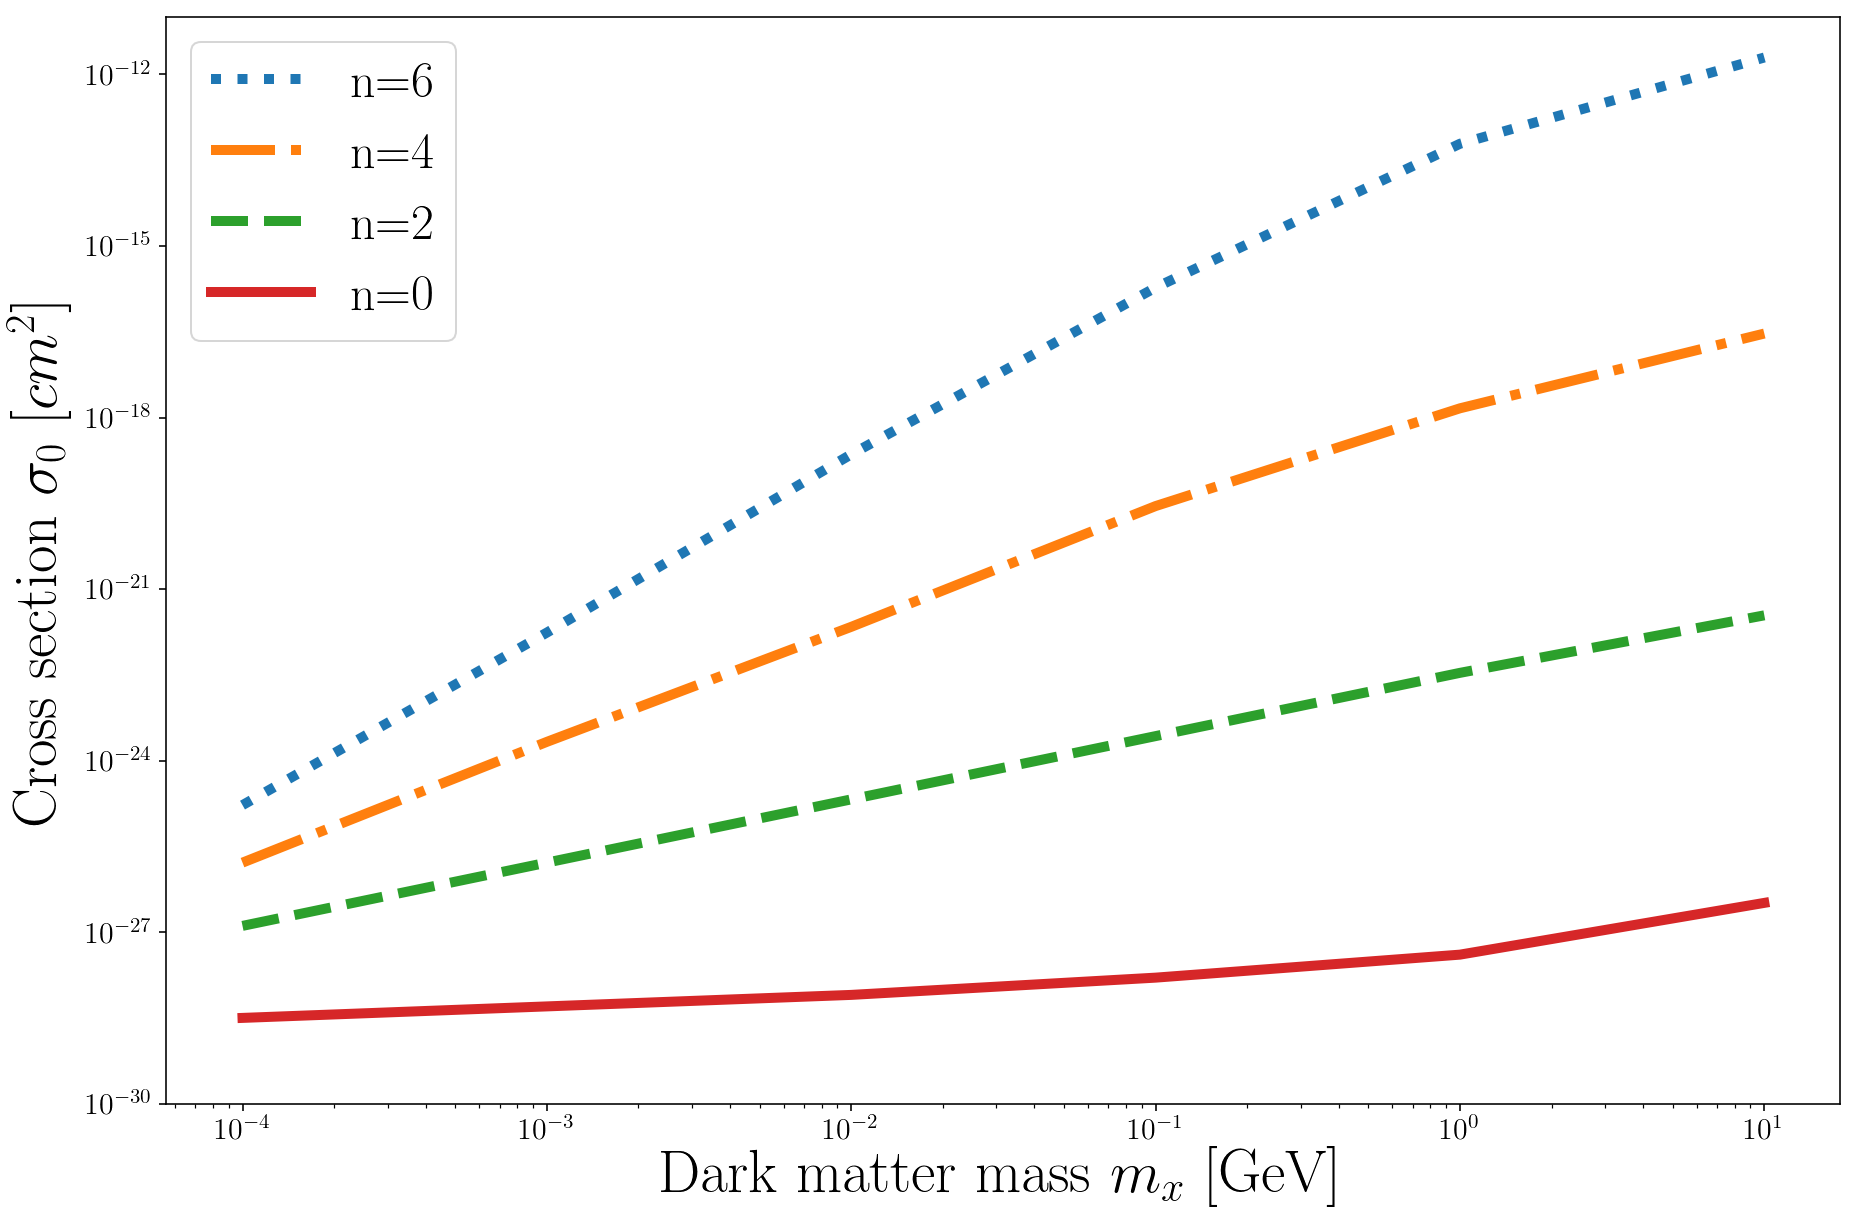

In [42]:
klim = mhm2khm(3*10**8)

plt.figure(figsize=(15,10))

plt.loglog(masses, sig(klim,6.), label="n=6",linewidth=5,linestyle=':')
plt.loglog(masses, sig(klim,4.), label="n=4",linewidth=5,linestyle='-.')
plt.loglog(masses, sig(klim,2.), label="n=2",linewidth=5,linestyle='--')
plt.loglog(masses, sig(klim,0.), label="n=0",linewidth=5)

# plt.title(r"Analytical", fontsize=20)
plt.ylabel(r"Cross section $\sigma_0$ [$cm^2$]", fontsize=30)
plt.xlabel(r"Dark matter mass $m_x$ [GeV]", fontsize=30)
plt.legend(fontsize=25)
plt.tick_params(labelsize=15)
plt.ylim(1e-30,1e-11)

plt.savefig("analytical.png")

Noice

---